Сентимент-анализ текстов о хоккее в русскоязычных и англоязычных СМИ с использованием ML. Сравнение со словарным методом. Обучение двуязычной модели для анализа тональностей.

Райманова Алия Азатовна

In [ ]:
import pandas as pd
import re

In [ ]:
ru_df = pd.read_json("khl_articles_summer.jsonl", lines=True)
ru_texts = ru_df["text"].tolist()
ru_texts[:2]

['Потому что нюанс у этого подписания огромный.\xa0\n\n\r\nПосле смены руководства\xa0СКА\xa0не провел ни одного трансфера. Рынок с каждым днем становится все менее привлекательным, а клуб из Санкт-Петербурга в межсезонье потерял много лидеров - Бардаков, Грицюк, Никишин и Демидов. Однако понять отсутствие переходов можно, так как новым людям нужно время, чтобы разобраться в нюансах и хоккейных деталях. Да и не сказать, что команда из Питера ничего не делает. Ходили ведь слухи об интересе к Голдобину и Локтионову.\xa0\n\n\n\n\n\n\r\nСовсем недавно сообщалось, что команду с берегов Невы пополнит Ларионов-младший - сын нового главного тренера СКА. И касательно этого перехода есть большие сомнения. Потому что переход родственника - это всегда риск. Потому что в коллективе климат может стать хуже. Потому что так или иначе многие будут задаваться вопросами касательно игрового времени, стиля и набранных баллов. Если родственник главного тренера заходит в команду, то должен давать максимальны

In [ ]:
en_df = pd.read_json("nhl_articles_summer.jsonl", lines=True)
en_texts = en_df["text"].tolist()
en_texts[:2]

["Six weeks out from the March 7 trade deadline, the market is still taking shape.\nActivity has slowed after a flurry of moves earlier in the season, and it’s still unclear what direction a cluster of teams hovering around the Eastern Conference wild-card picture are going to go.\nAnother wrinkle comes in the form of the upcoming 4 Nations Face-Off, which will see the NHL schedule halted for 12 days in February and may push the bulk of trades into a two-week period leading into the deadline.\nAdvertisement\nConsider this the calm before the storm.\nAs we take stock of what’s to come, it’s the return of the Big Board with nine new targets, including a few top-of-the-lineup stars. Players are listed by how closely they demand watching, based on their potential impact and the current amount of buzz around them.\nNote: Net Ratings and market values are via Dom Luszczyszyn’s model and are projected for the full season based on statistics through Jan. 22. Goals saved above expected (GSAx) a

Предобработка.

In [ ]:
def preprocess_text(text):
    text = text.replace("\xa0", " ")              # неразрывные пробелы
    text = text.replace("\r", " ").replace("\n", " ")  # переносы строк
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # ссылки
    text = re.sub(r"<.*?>", "", text)             # HTML-теги, если есть
    text = re.sub(r"\s+", " ", text)              # нормализуем пробелы
    return text.strip()

In [ ]:
ru_texts_clean = [preprocess_text(text) for text in ru_texts]
en_texts_clean = [preprocess_text(text) for text in en_texts]

In [ ]:
ru_texts_clean[:2]

['Потому что нюанс у этого подписания огромный. После смены руководства СКА не провел ни одного трансфера. Рынок с каждым днем становится все менее привлекательным, а клуб из Санкт-Петербурга в межсезонье потерял много лидеров - Бардаков, Грицюк, Никишин и Демидов. Однако понять отсутствие переходов можно, так как новым людям нужно время, чтобы разобраться в нюансах и хоккейных деталях. Да и не сказать, что команда из Питера ничего не делает. Ходили ведь слухи об интересе к Голдобину и Локтионову. Совсем недавно сообщалось, что команду с берегов Невы пополнит Ларионов-младший - сын нового главного тренера СКА. И касательно этого перехода есть большие сомнения. Потому что переход родственника - это всегда риск. Потому что в коллективе климат может стать хуже. Потому что так или иначе многие будут задаваться вопросами касательно игрового времени, стиля и набранных баллов. Если родственник главного тренера заходит в команду, то должен давать максимальный результат со старта, чтобы зареком

In [ ]:
en_texts_clean[:2]

["Six weeks out from the March 7 trade deadline, the market is still taking shape. Activity has slowed after a flurry of moves earlier in the season, and it’s still unclear what direction a cluster of teams hovering around the Eastern Conference wild-card picture are going to go. Another wrinkle comes in the form of the upcoming 4 Nations Face-Off, which will see the NHL schedule halted for 12 days in February and may push the bulk of trades into a two-week period leading into the deadline. Advertisement Consider this the calm before the storm. As we take stock of what’s to come, it’s the return of the Big Board with nine new targets, including a few top-of-the-lineup stars. Players are listed by how closely they demand watching, based on their potential impact and the current amount of buzz around them. Note: Net Ratings and market values are via Dom Luszczyszyn’s model and are projected for the full season based on statistics through Jan. 22. Goals saved above expected (GSAx) are via

Модель для английских текстов.

In [ ]:
from tqdm import tqdm

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
import torch.nn.functional as F

In [ ]:
eng_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
eng_tokenizer = AutoTokenizer.from_pretrained(eng_model_name)
eng_model = AutoModelForSequenceClassification.from_pretrained(eng_model_name)

Модель может обрабатывать тексты размером не более 512 токенов. Разделим статьи на чанки размером 512 токенов и меньше.

In [ ]:
def split_into_chunks(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i+max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]


In [ ]:
import numpy as np

In [ ]:
chunks_data = {}  # глобальный словарь

def predict_sentiment(text, model, tokenizer, labels, text_id=None):
    tokens = tokenizer.tokenize(text)
    chunks = [tokenizer.convert_tokens_to_string(tokens[i:i+512]) for i in range(0, len(tokens), 512)]

    probs = []
    chunk_labels = []

    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        prob = F.softmax(outputs.logits, dim=1).squeeze().numpy()
        probs.append(prob)
        chunk_labels.append(labels[np.argmax(prob)])

    avg = np.mean(probs, axis=0)
    overall_label = labels[np.argmax(avg)]

    if text_id is not None:
        chunks_data[text_id] = {
            "chunks": chunks,  # уже восстановленные строки
            "chunk_labels": chunk_labels,
            "chunk_probs": probs
        }

    return overall_label



In [ ]:
labels_eng = ["negative", "neutral", "positive"]

Сохраним в список итоговую метку для каждой статьи(метка усреднена по чанкам).

In [ ]:
en_sentiments = []  # сюда сохраняем итоговую метку

for idx, text in tqdm(enumerate(en_texts_clean), total=len(en_texts_clean)):
    label = predict_sentiment(text, eng_model, eng_tokenizer, labels_eng, text_id=idx)
    en_sentiments.append(label)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [1:28:24<00:00,  5.30s/it]  


In [ ]:
en_df["sentiment"] = en_sentiments

In [ ]:
print(chunks_data[0])

{'chunks': ['Six weeks out from the March 7 trade deadline, the market is still taking shape. Activity has slowed after a flurry of moves earlier in the season, and it’s still unclear what direction a cluster of teams hovering around the Eastern Conference wild-card picture are going to go. Another wrinkle comes in the form of the upcoming 4 Nations Face-Off, which will see the NHL schedule halted for 12 days in February and may push the bulk of trades into a two-week period leading into the deadline. Advertisement Consider this the calm before the storm. As we take stock of what’s to come, it’s the return of the Big Board with nine new targets, including a few top-of-the-lineup stars. Players are listed by how closely they demand watching, based on their potential impact and the current amount of buzz around them. Note: Net Ratings and market values are via Dom Luszczyszyn’s model and are projected for the full season based on statistics through Jan. 22. Goals saved above expected (GS

In [ ]:
en_df.to_csv('en_sent_new.csv', encoding='utf-8')

Сделаем из словаря с информацией о чанках датафрейм для дальнейшего анализа

In [ ]:
def build_chunks_df(chunks_data):

    chunk_rows = []

    for text_id, data in chunks_data.items():
        chunks = data.get("chunks", [])
        labels = data.get("chunk_labels", [])
        probs = data.get("chunk_probs", [])

        # Проверяем, что всё одинаковой длины
        if len(chunks) == len(labels) == len(probs):
            for i in range(len(chunks)):
                row = {
                    "text_id": text_id,
                    "chunk_text": chunks[i],
                    "chunk_label": labels[i],
                    "chunk_probs": probs[i].tolist()
                }
                chunk_rows.append(row)

    return pd.DataFrame(chunk_rows)


In [ ]:
chunks_df = build_chunks_df(chunks_data)
chunks_df.to_csv('chunks_df.csv', encoding='utf-8')

In [ ]:
print("Английский корпус:\n", en_df["sentiment"].value_counts())

Английский корпус:
 sentiment
neutral     718
positive    253
negative     29
Name: count, dtype: int64


Модель для русских текстов.

In [ ]:
ru_model_path=r'C:\Users\Алия\Desktop\учеба\проект 2\модель'
ru_tokenizer = AutoTokenizer.from_pretrained(ru_model_path)
ru_model = AutoModelForSequenceClassification.from_pretrained(ru_model_path)


In [ ]:
labels_ru = ["negative", "neutral", "positive"]

In [ ]:
ru_sentiments = []  # сюда сохраняем итоговую метку 

for idx, text in tqdm(enumerate(ru_texts_clean), total=len(ru_texts_clean)):
    label = predict_sentiment(text, ru_model, ru_tokenizer, labels_ru, text_id=idx)
    ru_sentiments.append(label)

100%|██████████| 1000/1000 [1:39:38<00:00,  5.98s/it]     


In [ ]:
chunks_df_ru = build_chunks_df(chunks_data)

In [ ]:
chunks_df_ru.to_csv('chunks_df_ru.csv', encoding='utf-8')

In [ ]:
print (chunks_df_ru)

      text_id                                         chunk_text chunk_label  \
0           0  Потому что нюанс у этого подписания огромный. ...     neutral   
1           0  в Ларионове - младшем? Сейчас будто бы и нет. ...    negative   
2           0  можно отнести то, что он набирал более 20 очко...    negative   
3           1  Клубу нужно решить данную задачу. В межсезонье...    positive   
4           1  а может и продолжить карьеру в Северной Америк...    negative   
...       ...                                                ...         ...   
2319      998  " Салавата Юлаева ". " Знаю, что у них 60 - ки...    positive   
2320      998  назвать нельзя. Две команды сражались. Мне каж...    positive   
2321      999  " Салават Юлаев " победил " Ак Барс ", " Тракт...    positive   
2322      999  Ярославле. К " Локомотиву " приехал СКА, котор...    positive   
2323      999  шайб и пропустила три. Негативно, что две из т...    negative   

                                       

In [ ]:
ru_df["sentiment"] = ru_sentiments

In [ ]:
ru_df.to_csv('ru_sent.csv', encoding='utf-8')

In [ ]:
print("Русский корпус:\n", ru_df["sentiment"].value_counts())

Русский корпус:
 sentiment
neutral     488
negative    344
positive    168
Name: count, dtype: int64


Визуализируем полученные результаты и сравним их друг с другом.

In [1]:
import matplotlib.pyplot as plt

In [10]:
en_path= r'c:\Users\Алия\Desktop\учеба\проект 2\en_sent.csv'
ru_path= r'c:\Users\Алия\Desktop\учеба\проект 2\ru_sent.csv'

In [16]:
ru_sent = pd.read_csv(ru_path)
en_sent = pd.read_csv(en_path)

In [17]:
ru_counts = ru_sent["sentiment"].value_counts()
en_counts = en_sent["sentiment"].value_counts()

In [18]:
labels = ["positive", "neutral", "negative"]
ru_sizes = [ru_counts.get(label, 0) for label in labels]
en_sizes = [en_counts.get(label, 0) for label in labels]
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

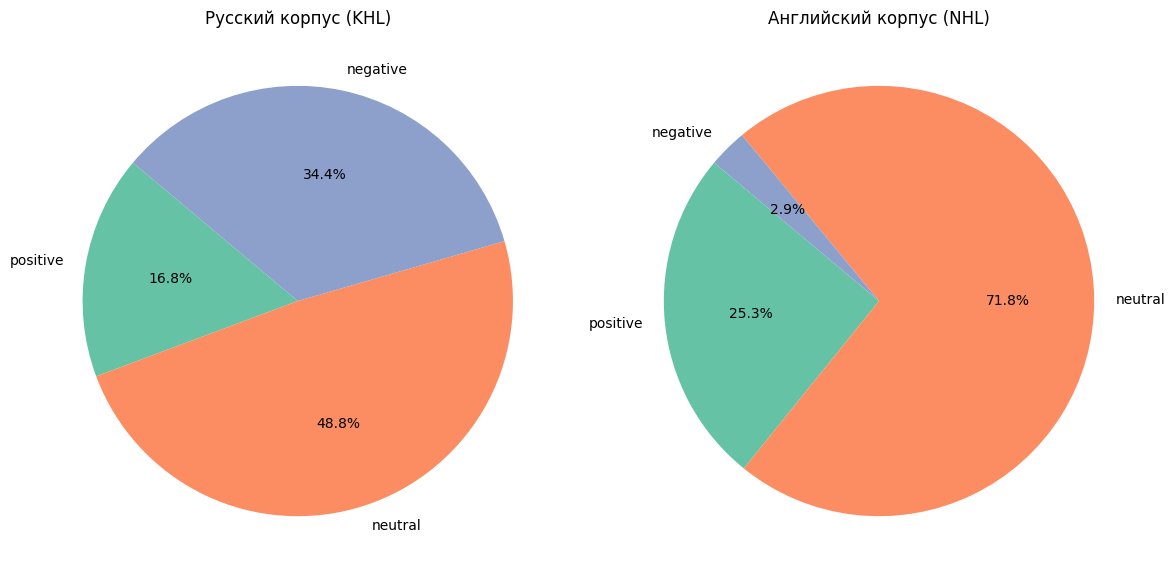

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(ru_sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
axes[0].set_title("Русский корпус (KHL)")
axes[1].pie(en_sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
axes[1].set_title("Английский корпус (NHL)")
plt.tight_layout()
plt.show()

На основе полученной разметки попробуем обучить новую модель сентимент-анализа, работающую с двумя языками. 

In [7]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

c:\Users\Алия\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
en_chunks_path = "chunks_df.csv"
ru_chunks_path = "chunks_df_ru.csv"

In [ ]:
ru_chunks_sent = pd.read_csv(ru_chunks_path)
en_chunks_sent = pd.read_csv(en_chunks_path)
print(len(ru_chunks_sent))
print(len(en_chunks_sent))

2324
5073


In [ ]:
ru_chunks_sent["lang"] = "ru"
en_chunks_sent["lang"] = "en"
train_chunks = pd.concat([ru_chunks_sent, en_chunks_sent], ignore_index=True)

In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_chunks['label'] = train_chunks['chunk_label'].map(label_map)

In [ ]:
min_class_count = train_chunks['label'].value_counts().min()

In [ ]:
print(min_class_count)

1065


In [ ]:
balanced_chunks = pd.concat([
    train_chunks[train_chunks["label"] == 0].sample(n=min_class_count, random_state=42),
    train_chunks[train_chunks["label"] == 1].sample(n=min_class_count, random_state=42),
    train_chunks[train_chunks["label"] == 2].sample(n=min_class_count, random_state=42),
], ignore_index=True)

In [ ]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Стратификация

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_chunks["chunk_text"].tolist(),
    balanced_chunks["label"].tolist(),
    test_size=0.2,
    stratify=balanced_chunks["label"],
    random_state=42
)

Токенизация. 

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=384) #максимальная длина чанка уменьшена для облегчения модели
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=384)

Подготовка данных для модели

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

In [ ]:
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    # Сохранение модели после каждой эпохи
    model.save_pretrained(f"saved_model_xlmr_epoch{epoch}")
    tokenizer.save_pretrained(f"saved_model_xlmr_epoch{epoch}")

Epoch 2:   0%|          | 3/639 [01:20<4:44:23, 26.83s/it, loss=0.931]


KeyboardInterrupt: 

После первой эпохи лосс начал расти, дальнейшее обучение остановлено, в дальнейшем используется толькообучение на одной эпохе.

In [ ]:
!zip -r saved_model_xlmr_epoch0.zip saved_model_xlmr_epoch0

  adding: saved_model_xlmr_epoch0/ (stored 0%)
  adding: saved_model_xlmr_epoch0/config.json (deflated 52%)
  adding: saved_model_xlmr_epoch0/special_tokens_map.json (deflated 52%)
  adding: saved_model_xlmr_epoch0/tokenizer.json (deflated 76%)
  adding: saved_model_xlmr_epoch0/tokenizer_config.json (deflated 76%)
  adding: saved_model_xlmr_epoch0/sentencepiece.bpe.model (deflated 49%)
  adding: saved_model_xlmr_epoch0/.ipynb_checkpoints/ (stored 0%)
  adding: saved_model_xlmr_epoch0/model.safetensors (deflated 27%)


In [ ]:
from google.colab import files
files.download('saved_model_xlmr_epoch0.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("saved_model_xlmr_epoch0")
tokenizer = AutoTokenizer.from_pretrained("saved_model_xlmr_epoch0")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

Оценка.

In [ ]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

In [ ]:
acc = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average="macro")
print(f"\nValidation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Validation Accuracy: 0.4726
Validation F1 Score: 0.3834
